**The Data Science Method**


1.   [Problem Identification](https://medium.com/@aiden.dataminer/the-data-science-method-problem-identification-6ffcda1e5152)

2.   [Data Wrangling](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-data-collection-organization-and-definitions-d19b6ff141c4)
  * Data Collection - Collected data from wikipedia and quandl wiki price dataset. The wikipedia showed us the currect S&P 500 companies and used their ticker symbols to query quandl wiki prices.
  * Data Organization - Done using cookiecutter
  * Data Definition
  * Data Cleaning - The S&P 500 data from quandls wiki price is clean and ready for analysis use but has lost its support from Quandl community as of April 11, 2018. So we will use this dataset to setup the protfolio optimizer with proof of concept then use a different data source later for cost efficiencies.

3.   [Exploratory Data Analysis](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-exploratory-data-analysis-bc84d4d8d3f9)
 * Build data profile tables and plots
        - Cumulative Return
        - Annualized Return
        - Daily Return
        - Mean Daily Return
        - Standard Deviation Daily Return
        - Simple Moving Average
        - Exponential Moving Average
        - Moving Average Convergence Divergence
        - Adj. Close & Daily Return Covariance
        - Adj. Close & Daily Return Correlation
        - Sharpe Ratio
        - Skew 
        - Kurtosis
 * Explore data relationships
 * Identification and creation of features 

4.   [**Pre-processing and Training Data Development**](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-pre-processing-and-training-data-development-fd2d75182967)
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
5.   [Modeling](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-modeling-56b4233cad1b)
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   [Documentation](https://medium.com/@aiden.dataminer/the-data-science-method-dsm-documentation-c92c28bd45e6)

  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code
  * Finalize Documentation


First, loads the needed packages and modules into Python. Then loads the data into a pandas dataframe for ease of use.

In [1]:
#load python packages
import os
import pandas as pd
import random
import datetime as dt
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
random.seed(42)

In [3]:
# prints current directory
current_dir = os.getcwd()
print("Current Directory: ")
print(current_dir)

Current Directory: 
/Users/jb/Development/courses/springboard/ds/Assignments/Portfolio-Optimization/portopt/notebooks/exploratory


In [4]:
# prints parent directory
project_dir = os.path.abspath(os.path.join(os.path.join(current_dir, os.pardir), os.pardir))
print("Parent Directory: ")
print(project_dir)

Parent Directory: 
/Users/jb/Development/courses/springboard/ds/Assignments/Portfolio-Optimization/portopt


In [5]:
print(os.listdir())

['3.0-jujbates-S&P500-PO_eda.ipynb', '.DS_Store', '5.0-jujbates-S&P500-PO_modeling.ipynb', '4.0-jujbates-S&P500-PO_pre-processing_and_training_data_development.ipynb', '.ipynb_checkpoints', '1.0-jujbates-S&P500-PO_problem_identification.ipynb', '2.0-jujbates-S&P500-PO_data_wrangling.ipynb']


In [6]:
plt.style.use('dark_background')
c = ['white', 'springgreen', 'fuchsia', 'lightcoral', 'red'] # Color
s = [24, 20, 16, 12]  # Size
w = [0.75, 1, 1.25, 1.50] # Line Width
ga = 0.10 # Grid Alpha

In [7]:
sp500_adj_close_df = pd.read_csv(project_dir + '/data/interim/'+ 'yahoo_sp500_adj_close_interim.csv', index_col=['date'])
sp500_index_adj_close_df = pd.read_csv(project_dir + '/data/interim/'+ 'yahoo_sp500_index_adj_close_interim.csv', index_col=['date'])

sp500_adj_close_df.index = pd.to_datetime(sp500_adj_close_df.index)
sp500_index_adj_close_df.index = pd.to_datetime(sp500_index_adj_close_df.index)


In [8]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_ef_max_sharpe_ratio(df):
    # Calculate expected returns and sample covariance
    mu = expected_returns.ema_historical_return(df)
    S = risk_models.semicovariance(df)

    # Optimise for maximal Sharpe ratio
    ef = EfficientFrontier(mu, S)
    raw_weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    
    # Expected return, Volatility, and the Sharpe ratio
    er, vol, sr = ef.portfolio_performance()
    return cleaned_weights, er, vol, sr


    
def get_daily_portfolio_values(prices, allocs, sv):
    """ 
    Get the daily portfolio values.

    To get the daily values the function normalizes portfolio's adjusted closing prices, 
    allocates the normalized symbol by the portfolio allocations, scales to the the portfolio's 
    psition values with the start values and finally sums by each day.
  
    Parameters: 
    prices (dataFrame): Adjusted closing prices for symbols in portfolio  
    allocs (list): A list of 2 or more allocations to the stocks, must sum to 1.0
    sv (float): Start value of the portfolio
    

    Returns: 
    dataFrame: Portfolio values
  
    """
    
    normed_price = prices / prices.iloc[0]  # Normalize Adj Close Prices
    alloced_price = normed_price * allocs  # Allocated Normalize Adj Close Prices
    pos_val = alloced_price * sv  # Position Values
    return pos_val.sum(axis=1)  # Portfolio Values



In [9]:
def cumulative_return(df):
    return (df.iloc[-1] / df.iloc[0]) - 1

def daily_returns(df):
    return df.pct_change() * 100

def sharpe_ratio(adr, sddr, rfr=0):
    return (adr - rfr) / sddr 

In [10]:


def get_top_50_symbols_with_sharpe_ratio(date_ranges, df):
    sym_df = pd.DataFrame({})
    for sd, ed in tqdm(date_ranges):
        prices = df.copy(deep=True).loc[sd : ed]
        dr = daily_returns(prices)
        sr = sharpe_ratio(dr.mean(), dr.std(), rfr=0)
        idx = str(sd) + '-->' + str(ed)
        if len(sr) == 1 and sr.index[0] == '^GSPC':
            sym_df[idx] = sr.index.tolist()
        else:
            sym_df[idx] = sr.sort_values(ascending=False)[:20].index.tolist()
    return sym_df

In [11]:
def get_random_date_ranges(start_date='1999-01-01', end_date='2019-12-31', range_window=365, evaluation_window=365, n_ranges=3):
    random_date_ranges = []

    range_window_dd = dt.timedelta(days=range_window)
    evaluation_window_dd = dt.timedelta(days=evaluation_window)

    start_date =  dt.datetime.strptime('1999-01-01', '%Y-%m-%d') 
    end_date =  dt.datetime.strptime('2019-12-31', '%Y-%m-%d') - (range_window_dd + evaluation_window_dd)    
    
    time_between_dates = end_date - start_date
    days_between_dates = time_between_dates.days    
    
    for i in range(n_ranges):
        random_number_of_days = random.randrange(days_between_dates)        
        random_start_date = start_date + dt.timedelta(days=random_number_of_days)
        
        random_end_date = random_start_date + range_window_dd
        random_date_ranges.append((random_start_date, random_end_date))
    return random_date_ranges

In [12]:
def plot_portfolio_window_performance(pv_df, p_df):
        # Build plot figure
        fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 16))
        ax1.set_title(f"Portfolio Values", fontsize=s[1])
        ax1.set_xlabel(f"Date", fontsize=s[2])
        ax1.set_ylabel(f"Price", fontsize=s[2])
        
        # Plot the results
        pv_df.plot(kind='line', ax=ax1, legend=None)
        
        ax2.set_title(f"Cumulative Return Distribution", fontsize=s[1])
        ax2.set_xlabel(f"Cumulative Return (%)", fontsize=s[2])
        ax2.set_ylabel(f"Frequence", fontsize=s[2])
        
        # Plot the results
        sns.histplot(data=p_df, x='Cumulative Return', bins=30, ax=ax2)

        plt.show()

def portfolio_window_performance(prices, window_sym_df, projection_window_days=365, optimize=True, plot_flag=False):
    pv_df = pd.DataFrame(index=prices.index)
    dr_df = pd.DataFrame(index=prices.index)
    performance_df = pd.DataFrame(index=window_sym_df.columns)
    performance_df['Cumulative Return'] = 0
    for i in window_sym_df:
        sv = 1
        ii = i.split('-->')
        sd = dt.datetime.strptime(ii[0], '%Y-%m-%d %H:%M:%S') 
        ed = dt.datetime.strptime(ii[1], '%Y-%m-%d %H:%M:%S')   
        dd = dt.timedelta(days=projection_window_days)
        
        sym_list = window_sym_df[i].to_list()
        w_prices = prices.loc[sd:ed, sym_list].copy(deep=True)
        if optimize:
            cleaned_weights, er, vol, sr = optimize_ef_max_sharpe_ratio(w_prices)
            allocs = pd.DataFrame({'cleaned_weights': cleaned_weights}, index=w_prices.columns)['cleaned_weights'].to_list()
        else:
            allocs = 1  
        e_price = prices.loc[ed:ed+dd, sym_list]

        pv = get_daily_portfolio_values(e_price, allocs, sv=sv)
        pv_df.insert(0, i, pd.Series(pv, index=e_price.index))
        
        cr = cumulative_return(pv_df.loc[ed:ed+dd, i])            
        performance_df.loc[i, 'Cumulative Return'] = cr * 100

    pv = get_daily_portfolio_values(e_price, allocs, sv=sv)
    
    if plot_flag:
        plot_portfolio_window_performance(pv_df, performance_df)
        
       
    return performance_df


In [13]:
rand_one_year_window_date_ranges = get_random_date_ranges(n_ranges=5)

rand_one_year_window_sym_50_df = get_top_50_symbols_with_sharpe_ratio(rand_one_year_window_date_ranges, sp500_adj_close_df)
rand_one_year_window_sp500_index_df = get_top_50_symbols_with_sharpe_ratio(rand_one_year_window_date_ranges, sp500_index_adj_close_df)

100%|██████████| 5/5 [00:00<00:00, 450.29it/s]


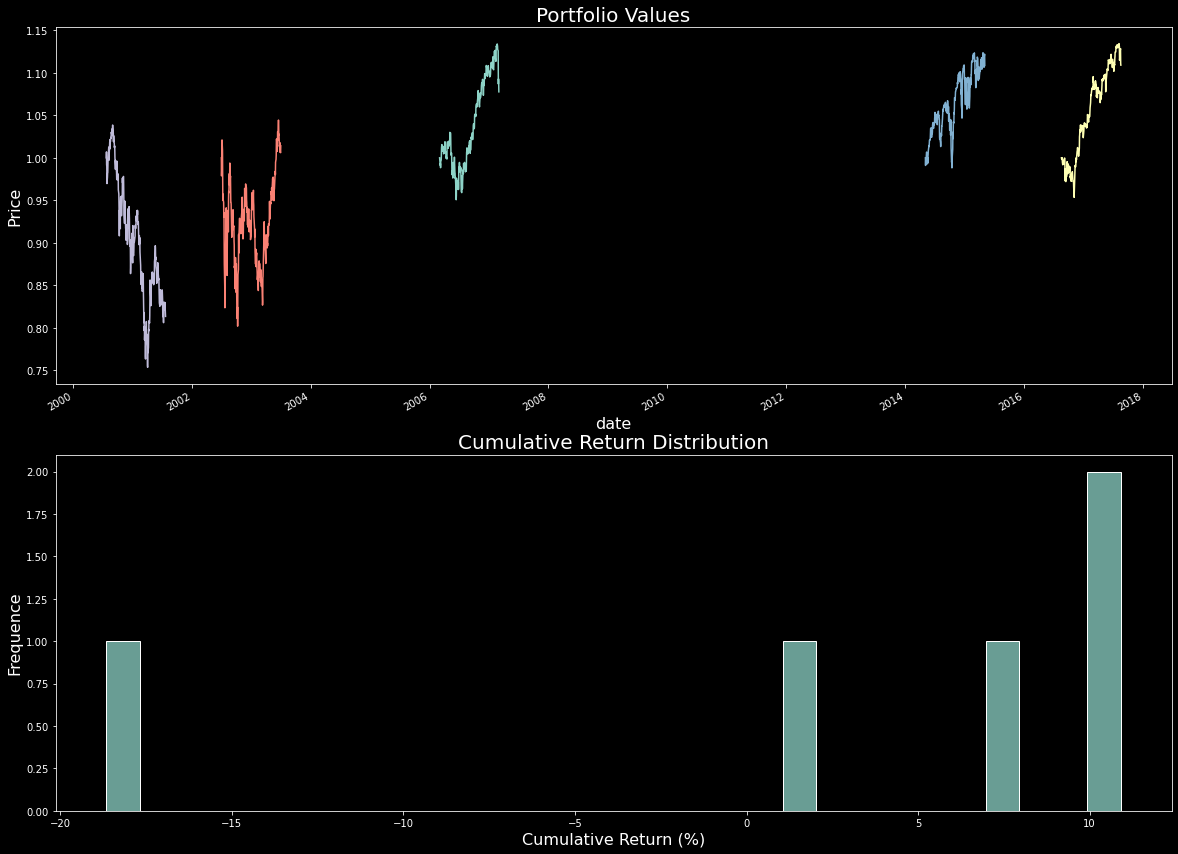

In [14]:
sp500_index_performance_df = portfolio_window_performance(sp500_index_adj_close_df, rand_one_year_window_sp500_index_df, projection_window_days=365, optimize=False, plot_flag=True)

In [15]:
rand_one_year_window_sym_50_df.index.name = 'index'
rand_one_year_window_sp500_index_df.index.name = 'index'

rand_one_year_window_sym_50_df.to_csv(project_dir + '/data/interim/'+ 'sp500_rand_one_year_window_sym_50_interim.csv', index=True)
rand_one_year_window_sp500_index_df.to_csv(project_dir + '/data/interim/'+ 'sp500_rand_one_year_window_sp500_index_interim.csv', index=True)